In [1]:
import numpy as np
from sklearn import datasets
import seaborn as sns

all_categories = ['alt.atheism','comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
                  'comp.sys.mac.hardware','comp.windows.x', 'misc.forsale','rec.autos','rec.motorcycles',
                  'rec.sport.baseball','rec.sport.hockey','sci.crypt','sci.electronics','sci.med',
                  'sci.space','soc.religion.christian','talk.politics.guns','talk.politics.mideast',
                  'talk.politics.misc','talk.religion.misc']

selected_categories = ['alt.atheism','comp.graphics','rec.sport.hockey','sci.space','talk.politics.misc']

X_train, Y_train = datasets.fetch_20newsgroups(subset="train", categories=selected_categories, return_X_y=True)
X_test , Y_test  = datasets.fetch_20newsgroups(subset="test", categories=selected_categories, return_X_y=True)

X_train = np.array(X_train)
X_test = np.array(X_test)

classes = np.unique(Y_train)
mapping = dict(zip(classes, selected_categories))

len(X_train), len(X_test), classes, mapping

(2722,
 1811,
 array([0, 1, 2, 3, 4]),
 {0: 'alt.atheism',
  1: 'comp.graphics',
  2: 'rec.sport.hockey',
  3: 'sci.space',
  4: 'talk.politics.misc'})

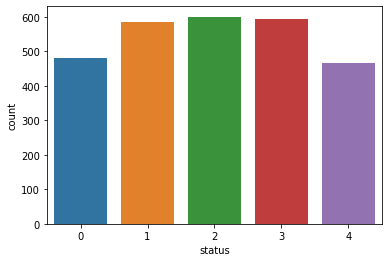

In [13]:
import pandas as pd
res = pd.DataFrame(Y_train,columns=['status'])
sns.countplot(data = res,x='status')

In [2]:
import keras
text_vectorizer = keras.layers.TextVectorization(max_tokens=None, standardize="lower_and_strip_punctuation",
                                                 split="whitespace", output_mode="count")

text_vectorizer

In [3]:
import gc
text_vectorizer.adapt(X_train, batch_size=512)

gc.collect()

651

In [4]:
vocab = text_vectorizer.get_vocabulary()
print("Vocab : {}".format(vocab[:10]))
print("Vocab Size : {}".format(text_vectorizer.vocabulary_size()))

out = text_vectorizer(X_train[:5])
print("Output Shape : {}".format(out.shape))

out

Vocab : ['[UNK]', 'the', 'to', 'of', 'a', 'and', 'in', 'is', 'that', 'i']
Vocab Size : 47345
Output Shape : (5, 47345)


<tf.Tensor: shape=(5, 47345), dtype=float32, numpy=
array([[  0.,   6.,   2., ...,   0.,   0.,   0.],
       [  0.,  15.,  11., ...,   0.,   0.,   0.],
       [  0.,   2.,   2., ...,   0.,   0.,   0.],
       [  0.,  36.,  31., ...,   0.,   0.,   0.],
       [  0., 145.,  66., ...,   0.,   0.,   0.]], dtype=float32)>

In [5]:
text_vectorizer = keras.layers.TextVectorization(max_tokens=50000, standardize="lower_and_strip_punctuation",
                                                 split="whitespace", output_mode="count", pad_to_max_tokens=True)

text_vectorizer.adapt(np.concatenate((X_train, X_test)), batch_size=512)

vocab = text_vectorizer.get_vocabulary()
print("Vocab : {}".format(vocab[:10]))
print("Vocab Size : {}".format(text_vectorizer.vocabulary_size()))
out = text_vectorizer(X_train[:5])
print("Output Shape : {}".format(out.shape))

Vocab : ['[UNK]', 'the', 'to', 'of', 'a', 'and', 'in', 'is', 'that', 'i']
Vocab Size : 50000
Output Shape : (5, 50000)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def create_model(text_vectorizer):
    return Sequential([
                        layers.Input(shape=(1,), dtype="string"),
                        text_vectorizer,
                        #layers.Dense(256, activation="relu"),
                        layers.Dense(128, activation="relu"),
                        layers.Dense(64, activation="relu"),
                        layers.Dense(len(classes), activation="softmax"),
                    ])

model = create_model(text_vectorizer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 50000)            0         
 ectorization)                                                   
                                                                 
 dense (Dense)               (None, 128)               6400128   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 6,408,709
Trainable params: 6,408,709
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

In [8]:
history = model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_test, Y_test))
gc.collect()

Epoch 1/10
11/11 [==============================] - 5s 400ms/step - loss: 1.1522 - accuracy: 0.7145 - val_loss: 0.6796 - val_accuracy: 0.9150
Epoch 2/10
11/11 [==============================] - 5s 442ms/step - loss: 0.2729 - accuracy: 0.9838 - val_loss: 0.3256 - val_accuracy: 0.9376
Epoch 3/10
11/11 [==============================] - 3s 244ms/step - loss: 0.0657 - accuracy: 0.9949 - val_loss: 0.2512 - val_accuracy: 0.9459
Epoch 4/10
11/11 [==============================] - 3s 244ms/step - loss: 0.0227 - accuracy: 0.9989 - val_loss: 0.2333 - val_accuracy: 0.9475
Epoch 5/10
11/11 [==============================] - 3s 245ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.2310 - val_accuracy: 0.9470
Epoch 6/10
11/11 [==============================] - 3s 247ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.2303 - val_accuracy: 0.9481
Epoch 7/10
11/11 [==============================] - 3s 247ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.2272 - val_accuracy: 0.9492
Epoch 

1405

In [9]:
from sklearn.metrics import accuracy_score, classification_report

train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("Train Accuracy : {}".format(accuracy_score(Y_train, np.argmax(train_preds, axis=1))))
print("Test  Accuracy : {}".format(accuracy_score(Y_test, np.argmax(test_preds, axis=1))))
print("\nClassification Report : ")
print(classification_report(Y_test, np.argmax(test_preds, axis=1), target_names=selected_categories))

Train Accuracy : 1.0
Test  Accuracy : 0.9475427940364439

Classification Report : 
                    precision    recall  f1-score   support

       alt.atheism       0.96      0.92      0.94       319
     comp.graphics       0.93      0.97      0.95       389
  rec.sport.hockey       0.97      0.98      0.97       399
         sci.space       0.95      0.94      0.94       394
talk.politics.misc       0.93      0.92      0.93       310

          accuracy                           0.95      1811
         macro avg       0.95      0.95      0.95      1811
      weighted avg       0.95      0.95      0.95      1811



In [10]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


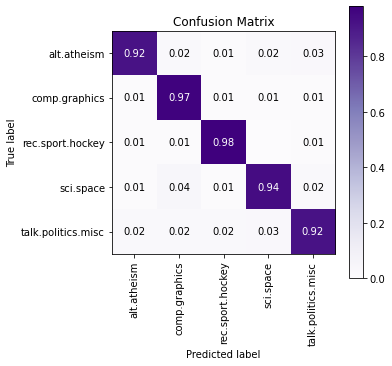

In [11]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix([selected_categories[i] for i in Y_test],
                                    [selected_categories[i] for i in np.argmax(test_preds, axis=1)],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

In [34]:
text_vectorizer = keras.layers.TextVectorization(max_tokens=50000, standardize="lower_and_strip_punctuation",
                                                 split="whitespace", output_mode="tf_idf", pad_to_max_tokens=True)

text_vectorizer.adapt(np.concatenate((X_train, X_test)), batch_size=512)
gc.collect()

model = create_model(text_vectorizer)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_test, Y_test))
gc.collect()

Epoch 1/10
11/11 [==============================] - 3s 246ms/step - loss: 0.7212 - accuracy: 0.8292 - val_loss: 0.2981 - val_accuracy: 0.9382
Epoch 2/10
11/11 [==============================] - 2s 219ms/step - loss: 0.0516 - accuracy: 0.9952 - val_loss: 0.2953 - val_accuracy: 0.9337
Epoch 3/10
11/11 [==============================] - 2s 219ms/step - loss: 0.0128 - accuracy: 0.9996 - val_loss: 0.2666 - val_accuracy: 0.9470
Epoch 4/10
11/11 [==============================] - 2s 218ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.3197 - val_accuracy: 0.9387
Epoch 5/10
11/11 [==============================] - 2s 219ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3368 - val_accuracy: 0.9354
Epoch 6/10
11/11 [==============================] - 4s 403ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3383 - val_accuracy: 0.9371
Epoch 7/10
11/11 [==============================] - 3s 263ms/step - loss: 9.1941e-04 - accuracy: 1.0000 - val_loss: 0.3351 - val_accuracy: 0.9376
Ep

1405

In [36]:
text_vectorizer = keras.layers.TextVectorization(max_tokens=50000, standardize="lower_and_strip_punctuation",
                                                 split="whitespace", output_mode="multi_hot",
                                                 pad_to_max_tokens=True)

text_vectorizer.adapt(np.concatenate((X_train, X_test)), batch_size=512)
gc.collect()

model = create_model(text_vectorizer)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, Y_train, batch_size=256, epochs=10, validation_data=(X_test, Y_test))
gc.collect()

Epoch 1/10
11/11 [==============================] - 3s 261ms/step - loss: 1.1079 - accuracy: 0.7395 - val_loss: 0.6147 - val_accuracy: 0.9304
Epoch 2/10
11/11 [==============================] - 2s 229ms/step - loss: 0.2099 - accuracy: 0.9893 - val_loss: 0.2854 - val_accuracy: 0.9359
Epoch 3/10
11/11 [==============================] - 2s 228ms/step - loss: 0.0434 - accuracy: 0.9974 - val_loss: 0.2208 - val_accuracy: 0.9464
Epoch 4/10
11/11 [==============================] - 2s 231ms/step - loss: 0.0146 - accuracy: 0.9993 - val_loss: 0.2103 - val_accuracy: 0.9453
Epoch 5/10
11/11 [==============================] - 2s 227ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.2017 - val_accuracy: 0.9464
Epoch 6/10
11/11 [==============================] - 2s 230ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 0.9459
Epoch 7/10
11/11 [==============================] - 2s 229ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2006 - val_accuracy: 0.9459
Epoch 

1405

In [38]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.1 MB/s 


In [39]:
import shap
shap.initjs()

In [40]:
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(model, masker=masker, output_names=selected_categories)

explainer

In [41]:
import re

X_batch = X_test[3:5]

print("Samples : ")
for text in X_batch:
    print(re.split(r"\W+", text))
    print()

preds_proba = model.predict(X_batch)
preds = preds_proba.argmax(axis=1)

print("Actual    Target Values : {}".format([selected_categories[target] for target in Y_test[3:5]]))
print("Predicted Target Values : {}".format([selected_categories[target] for target in preds]))
print("Predicted Probabilities : {}".format(preds_proba.max(axis=1)))

shap_values = explainer([text.lower() for text in X_batch]) ## Generate SHAP VAlues

Samples : 
['From', 'STK1203', 'VAX003', 'STOCKTON', 'EDU', 'Subject', 'Internet', 'resources', 'X', 'Added', 'Forwarded', 'by', 'Space', 'Digest', 'Organization', 'via', 'International', 'Space', 'University', 'Original', 'Sender', 'isu', 'VACATION', 'VENARI', 'CS', 'CMU', 'EDU', 'Distribution', 'sci', 'Lines', '4', 'exit', '']

['From', 'kane', 'buast7', 'bu', 'edu', 'Hot', 'Young', 'Star', 'Subject', 'Re', 'New', 'Study', 'Out', 'On', 'Gay', 'Percentage', 'Organization', 'Astronomy', 'Department', 'Boston', 'University', 'Boston', 'MA', 'USA', 'Lines', '24', 'In', 'article', '15427', 'optilink', 'COM', 'cramer', 'optilink', 'COM', 'Clayton', 'Cramer', 'writes', 'Homosexuals', 'lie', 'about', 'the', '10', 'number', 'to', 'hide', 'the', 'disproportionate', 'involvement', 'of', 'homosexuals', 'in', 'child', 'molestation', 'They', 'also', 'lie', 'about', '10', 'to', 'keep', 'politicians', 'scared', '1', 'You', 'haven', 't', 'shown', 'any', 'disproportionate', 'involvement', '2', 'The', 

In [42]:
print("SHAP Values Shape : {}".format(shap_values.shape))
print("SHAP Base Values  : {}".format(shap_values.base_values))
print("SHAP Data : ")
print(shap_values.data[0])
print(shap_values.data[1])

SHAP Values Shape : (2, None, 5)
SHAP Base Values  : [[0.18070014 0.21967307 0.21603318 0.19633557 0.18725805]
 [0.18070014 0.21967307 0.21603318 0.19633557 0.18725805]]
SHAP Data : 
['from: ' 'stk1203@' 'vax003.' 'stockton.' 'edu\n' 'subject: ' 'internet '
 'resources\n' 'x-' 'added: ' 'forwarded ' 'by ' 'space ' 'digest\n'
 'organization: [' 'via ' 'international ' 'space ' 'university]\n'
 'original-' 'sender: ' 'isu@' 'vacation.' 'venari.' 'cs.' 'cmu.' 'edu\n'
 'distribution: ' 'sci\n' 'lines: ' '4\n\n' 'exit']
['from: ' 'kane@' 'buast7.' 'bu.' 'edu (' 'hot ' 'young ' 'star)\n'
 'subject: ' 're: ' 'new ' 'study ' 'out ' 'on ' 'gay ' 'percentage\n'
 'organization: ' 'astronomy ' 'department, ' 'boston ' 'university, '
 'boston, ' 'ma, ' 'usa\n' 'lines: ' '24\n\n' 'in ' 'article <' '15427@'
 'optilink.' 'com> ' 'cramer@' 'optilink.' 'com (' 'clayton ' 'cramer) '
 'writes:\n\n>' 'homosexuals ' 'lie ' 'about ' 'the ' '10% ' 'number '
 'to ' 'hide ' 'the ' 'disproportionate\n>' 'involve

In [43]:
shap.text_plot(shap_values)

In [12]:
model.save('./model')


INFO:tensorflow:Assets written to: ./model/assets


In [13]:
from tensorflow import keras
model = keras.models.load_model('./model')

In [14]:
model.predict(['this is a class'])

array([[0.19030587, 0.24081023, 0.17586143, 0.19263706, 0.20038539]],
      dtype=float32)

In [15]:
!zip -r model.zip model/ 

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 68%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 86%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 28%)
  adding: model/variables/variables.index (deflated 60%)


In [16]:
!mv model/ modelbk/

In [19]:
!unzip model.zip 

Archive:  model.zip
   creating: model/
  inflating: model/saved_model.pb    
   creating: model/assets/
  inflating: model/keras_metadata.pb  
   creating: model/variables/
  inflating: model/variables/variables.data-00000-of-00001  
  inflating: model/variables/variables.index  


In [18]:
!rm -rf model/

In [20]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### This is only for local testing / Collab testing

In [109]:
#%%writefile custom_processing.py

#import 
import pandas as pd
import pickle
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences


def preprocess(text):
    """Do all the Preprocessing as shown above and
    return a tuple contain preprocess_email,preprocess_subject,preprocess_text for that Text_data"""
         
    
    #After you store it in the list, Replace those sentances in original text by space.
    text = re.sub("(Subject:).+"," ",text,re.I)
    
    #Delete all the sentances where sentence starts with "Write to:" or "From:".
    text = re.sub("((Write to:)|(From:)).+","",text,re.I)
    
    #Delete all the tags like "< anyword >"
    text = re.sub("<[^><]+>","",text)
    
    #Delete all the data which are present in the brackets.
    text = re.sub("\([^()]+\)","",text)
    
    #Remove all the newlines('\n'), tabs('\t'), "-", "".
    text = re.sub("[\n\t\\-]+","",text)
    
    #Remove all the words which ends with ":".
    text = re.sub("(\w+:)","",text)
    
    #Decontractions, replace words like below to full words.

    lines = re.sub(r"n\'t", " not", text)
    lines = re.sub(r"\'re", " are", lines)
    lines = re.sub(r"\'s", " is", lines)
    lines = re.sub(r"\'d", " would", lines)
    lines = re.sub(r"\'ll", " will", lines)
    lines = re.sub(r"\'t", " not", lines)
    lines = re.sub(r"\'ve", " have", lines)
    lines = re.sub(r"\'m", " am", lines)
    text = lines
    
        #replace numbers with spaces
    text = re.sub("\d+"," ",text)
    
        # remove _ from the words starting and/or ending with _
    text = re.sub("(\s_)|(_\s)"," ",text)
    
        #remove 1 or 2 letter word before _
    text = re.sub("\w{1,2}_","",text)
    
        #convert all letters to lowercase and remove the words which are greater 
        #than or equal to 15 or less than or equal to 2.
    text = text.lower()
    
    text =" ".join([i for i in text.split() if len(i)<15 and len(i)>2])
    
    #replace all letters except A-Z,a-z,_ with space
    preprocessed_text = re.sub("\W+"," ",text)

    return preprocessed_text

def preprocess_tokenizing(text):
        
    #from tf.keras.preprocessing.text import Tokenizer
    #from tf.keras.preprocessing.sequence import pad_sequences
    
    tokenizer = pickle.load(open('tokenizer.pkl','rb'))

    max_length = 1019
    tokenizer.fit_on_texts([text])
    encoded_docs = tokenizer.texts_to_sequences([text])
    text_padded = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    
    return text_padded

import collections

def postprocess(vector):
    lookup =  {0: 'alt.atheism', \
      1: 'comp.graphics',\
      2: 'rec.sport.hockey',\
      3: 'sci.space',\
      4: 'talk.politics.misc'}

    d = dict(zip( vector,lookup.values()))
    return d
    


In [110]:
#import custom_processing

input = ['my name is here','space science  is good']
preprocessed_text_arr = [ preprocess(t) for t in input ] 
from tensorflow import keras
model = keras.models.load_model('./model')

predicted_result = model.predict(preprocessed_text_arr)
#print(predicted_result)
out = [ postprocess(t) for t in predicted_result  ]
out

[{0.16449057: 'talk.politics.misc',
  0.1940563: 'sci.space',
  0.19683968: 'alt.atheism',
  0.21517594: 'comp.graphics',
  0.22943746: 'rec.sport.hockey'},
 {0.13298348: 'talk.politics.misc',
  0.145691: 'alt.atheism',
  0.20434724: 'comp.graphics',
  0.21131054: 'rec.sport.hockey',
  0.30566776: 'sci.space'}]